In [14]:
#Modules used
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import random
import math
import scipy.stats
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import scipy.stats as stats

In [15]:
#Downloaded the daily stock price data for 2006-2008 using Yahoo Finance
date_start = dt.datetime(2006, 1, 1)
date_end = dt.datetime(2008, 12, 31)
tickers = ['GS', 'JPM', 'C', 'BCS', 'MS', 'DB', 'BAC', 'BNP.PA', 'CS', 'UBS']

data = yf.download(tickers, start=date_start, end=date_end)['Adj Close']
data = data.dropna()
data = data.pct_change(1).dropna()


[*********************100%***********************]  10 of 10 completed


C:\Users\anany\AppData\Local\Temp\ipykernel_21216\1055785245.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  VaRs = data[data.index >= pd.datetime(2008, 1, 1)] # initiate VaRs data frame
C:\Users\anany\AppData\Local\Temp\ipykernel_21216\1055785245.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VaRs.loc[VaRs.index == t,:] = np.array(data_tmp.apply(VaR_from_gains)) # calc VaR for each stock
C:\Users\anany\AppData\Local\Temp\ipykernel_21216\1055785245.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VaRs.loc

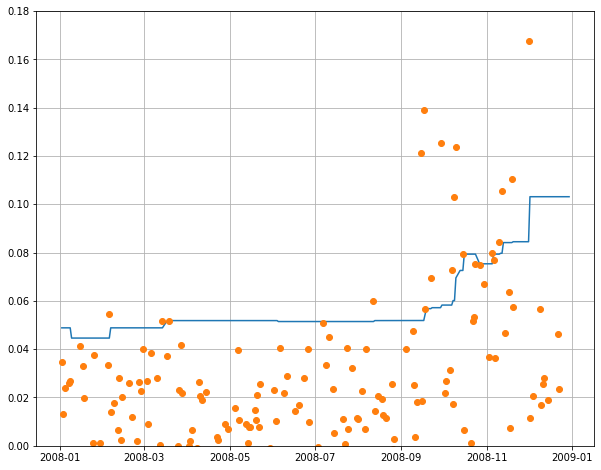

In [21]:
#Defined a function to find the 99% 1-day VaR
def VaR_from_gains(gains, c=0.99):
    n = len(gains)
    sort = sorted(gains)
    VaR = -sort[math.ceil(n * (1-c))-1]
    return VaR

#VaRs data frame
VaRs = data[data.index >= pd.datetime(2008, 1, 1)]

# filter to temporary expanding window data
#Use loc and apply the previously defined VaR function to calculate VaR for each stock
for t in VaRs.index:
    data_tmp = data[data.index < t]
    VaRs.loc[VaRs.index == t,:] = np.array(data_tmp.apply(VaR_from_gains))

#Create and display the plot
plt.figure(figsize=(10, 8)) 
plt.plot(VaRs['GS'])
plt.plot(-data[data.index >= pd.datetime(2008, 1, 1)]['GS'], 'o')
plt.ylim(0, 0.18)
plt.grid()
plt.show()

When plotting the time series of VaR, we observe that it breaks down during the financial crisis, as evident in the graph of Goldman Sachs above. To test whether the number of exceptions (days where losses exceeded VaR) was significantly high, we can employ a binomial test. The resulting p-value confirms that the number of exceptions was indeed too high.

This outcome aligns with intuition since using a VaR model estimated during normal times will likely yield an excessive number of exceptions during crisis periods. To address this issue, one approach is to assign more weight to recent observations in the VaR calculation. By incorporating more recent data, the model can capture the changing dynamics and provide more accurate risk estimates during crisis times.

In [24]:
#Create a function to find the p-Value of each stock and use it for our backtest
def calculate_p_value(ticker):
    N = len(VaRs[ticker])
    exceptions = sum(-data[data.index >= pd.datetime(2008, 1, 1)][ticker] > VaRs[ticker])
    p_value = 1 - stats.binom.cdf(exceptions - 1, N, 0.01)
    return p_value

In [25]:
for ticker in tickers:
    p_value = calculate_p_value(ticker)
    print(f"Ticker: {ticker}, p-value: {p_value}")

Ticker: GS, p-value: 1.259210513637754e-10
Ticker: JPM, p-value: 1.9395596240201485e-13
Ticker: C, p-value: 0.0
Ticker: BCS, p-value: 1.7712498134869747e-12
Ticker: MS, p-value: 1.259210513637754e-10
Ticker: DB, p-value: 2.020605904817785e-14
Ticker: BAC, p-value: 0.0
Ticker: BNP.PA, p-value: 1.7712498134869747e-12
Ticker: CS, p-value: 1.259210513637754e-10
Ticker: UBS, p-value: 1.9984014443252818e-15


C:\Users\anany\AppData\Local\Temp\ipykernel_21216\1851587926.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  exceptions = sum(-data[data.index >= pd.datetime(2008, 1, 1)][ticker] > VaRs[ticker])


In [18]:
#Calculate the Exceptions
N = len(VaRs['GS'])
exceptions = sum(-data[data.index >= pd.datetime(2008, 1, 1)]['GS'] > VaRs['GS'])
1 - scipy.stats.binom.cdf(exceptions-1, N, 0.01)

C:\Users\anany\AppData\Local\Temp\ipykernel_21216\470728661.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  exceptions = sum(-data[data.index >= pd.datetime(2008, 1, 1)]['GS'] > VaRs['GS'])


1.259210513637754e-10

In [26]:
#Added dataset of the daily stock price for all 10 banks over the same
#period.
#(a) Used the historical method to compute the VaR for a portfolio with
#$1m in the odd-numbered banks (1, 3, ...), $2m in the even-numbered
#banks.

In [13]:
#easier to use data as an array
portmatrix = np.array(data) 
#initial weights
initialweight = np.tile([1, 2], 5)
# create diagonal matrix with epsilons
deltamat = np.diag(np.tile([0.01], 10)) 

#Define a function to get VaR, DVaR and CVaR
def genportVaR(pmat, wgt, epsilon):
    ptf_ret = np.dot(pmat, wgt)
    eps_ret = np.dot(pmat, wgt + epsilon)
    
    ## Compute VaR based on initial weights
    VaR_ptf = VaR_from_gains(ptf_ret)
    ## Compute VaR based on permutated weights
    VaR_ptf_eps = VaR_from_gains(eps_ret)
    ## Calculate DVaR and CVaR
    DVaR = (VaR_ptf_eps - VaR_ptf)/sum(epsilon)
    CVaR = DVaR * wgt[np.where(epsilon != 0)[0][0]]
    return np.array([VaR_ptf, DVaR, CVaR])
VaRs = np.zeros(shape=(10,3))
VaRs = [genportVaR(portmatrix, initialweight, deltamat[i,]) for i in range(0, 10)]
VaRs = pd.DataFrame(VaRs)
VaRs.columns = ['VaR', 'DVaR', 'CVaR']
VaRs['Ticker'] = tickers
print(VaRs)

      VaR      DVaR      CVaR  Ticker
0  1.5571  0.111765  0.111765      GS
1  1.5571  0.114127  0.228255     JPM
2  1.5571 -0.054548 -0.054548       C
3  1.5571  0.102083  0.204167     BCS
4  1.5571  0.209112  0.209112      MS
5  1.5571  0.120889  0.241779      DB
6  1.5571  0.103098  0.103098     BAC
7  1.5571  0.066666  0.133332  BNP.PA
8  1.5571  0.258929  0.258929      CS
9  1.5571  0.060606  0.121212     UBS


The first column of the output represents the portfolio VaR, while the second and third rows correspond to DVaR and CVaR, respectively. The analysis reveals that the VaR measure is most influenced by the position held in Morgan Stanley, indicating that changes in the Morgan Stanley position have the greatest impact on the overall portfolio risk as captured by VaR.







When considering portfolio tilting, the objective is to maximize expected returns (or expected profit) per unit of capital, aligning with the concept of Risk-Adjusted Return on Capital (RAROC). Given our focus on portfolio changes, the ratio of expected returns (E[r]) to DVaR (Delta VaR) effectively captures this notion, allowing us to assess the potential for optimizing returns while considering risk.